<a href="https://colab.research.google.com/github/omkarnitsureiitb/Neural-Style-Transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Style Transfer**
## Author - Omkar Nitsure
### Email - omkarnitsure2003@gmail.com
### github - https://github.com/omkarnitsureiitb

In [ ]:
# importing useful libraries

# libraries for mathematics
import numpy as np

# libraries for plotting
import matplotlib.pyplot as plt

# libraries for data manipulation
import pandas as pd
import os

#libraries to display images
import cv2 as cv

# library for training the neural network
import tensorflow as tf

# displaying the image
from google.colab.patches import cv2_imshow

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# image size to be used for displaying
img_size = 450

## Loading the Pretrained VGG Network

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')

vgg.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


## Defining the layers to be used as Style Layers

In [ ]:
STYLE_LAYERS = [
  ('block1_conv1', 0.3),
  ('block2_conv1', 0.2),
  ('block3_conv1', 0.3),
  ('block4_conv1', 0.1),
  ('block5_conv1', 0.1)]

## Function to compute Gram Matrix

In [ ]:
def gram_matrix(A):

  Gram_Matrix = tf.matmul(A, tf.transpose(A))

  return Gram_Matrix

## Function to compute the loss from content image

In [ ]:
def content_cost(content_output, generated_output):

  a_C = content_output[-1]
  a_G = generated_output[-1]

  _, n_H, n_W, n_C = a_G.get_shape().as_list()

  a_C_unrolled = tf.reshape(a_C, [_, n_H*n_W, n_C])
  a_G_unrolled = tf.reshape(a_G, [_, n_H*n_W, n_C])

  J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))

  return J_content

## Function to compute the cost of a single Style layer

In [ ]:
def style_cost_layer(a_S, a_G):

  _, n_H, n_W, n_C = a_G.get_shape().as_list()

  a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
  a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

  GS = gram_matrix(a_S)
  GG = gram_matrix(a_G)

  J_style_layer = (1/(2*n_H*n_W*n_C)**2)*tf.reduce_sum(tf.square(tf.subtract(GS, GG)))

  return J_style_layer

## Function to compute the loss from the Style image

In [ ]:
def style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

  J_style = 0
  a_S = style_image_output[:-1]
  a_G = generated_image_output[:-1]

  for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
    J_style_layer = style_cost_layer(a_S[i], a_G[i])
    J_style += weight[1] * J_style_layer

  return J_style

## Defining the total cost function to be used by Backpropagation later

In [ ]:
@tf.function()
def total_cost(J_content, J_style, alpha = 20, beta = 80):

  J = alpha*J_content + beta*J_style

  return J

## Loading the content image

In [ ]:
path = "/content/drive/MyDrive/NST/Content_Images/"
image_name = "CI_5.png"

Image Dimensions- (450, 450, 3)


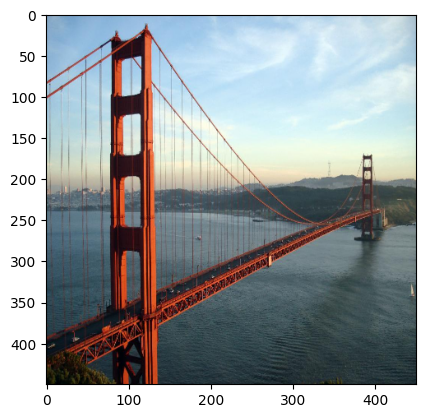

In [ ]:
content_image = cv.imread(path + image_name)
content_image = cv.resize(content_image, (img_size, img_size))
content_image = cv.cvtColor(content_image, cv.COLOR_BGR2RGB)

print("Image Dimensions-", content_image.shape)
plt.imshow(content_image)
plt.show()

## Loading the Style Image

In [ ]:
path = "/content/drive/MyDrive/NST/Style_Images/"
image_name = "SI_7.jpeg"

Image Dimensions- (450, 450, 3)


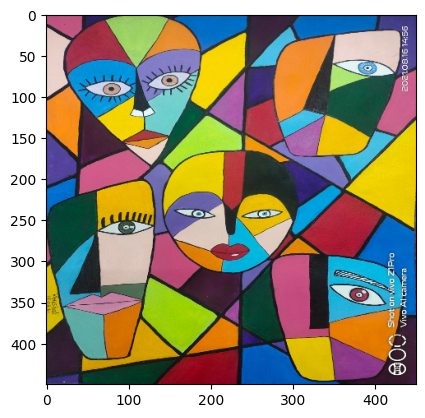

In [ ]:
style_image = cv.imread(path + image_name)
style_image = cv.resize(style_image, (img_size, img_size))
style_image = cv.cvtColor(style_image, cv.COLOR_BGR2RGB)

print("Image Dimensions-", content_image.shape)
plt.imshow(style_image)
plt.show()

## Creating the initial generated image by adding noise

Image Dimensions- (450, 450, 3)


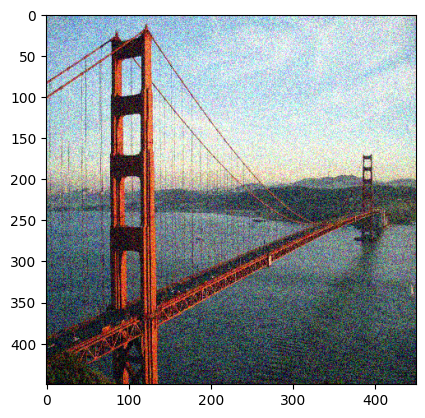

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print("Image Dimensions-", generated_image.shape)
plt.imshow(generated_image.numpy())
plt.show()

## Function to get the output of a layer

In [ ]:
def get_layer_outputs(vgg, layer_names):

  outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
  model = tf.keras.Model([vgg.input], outputs)

  return model

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

## Evaluating the desired outputs

In [ ]:
content_target = vgg_model_outputs(np.array([content_image]))
style_targets = vgg_model_outputs(np.array([style_image]))

In [ ]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(np.array([content_image]), tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [ ]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(np.array([style_image]), tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

## Function to resolve the exploding gradient problem

In [ ]:
def clip_0_1(image):

  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

## Defining the optimizer, learning rate and the training function in Tensorflow

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_function(generated_image):
  with tf.GradientTape() as tape:

    a_G = vgg_model_outputs(generated_image)

    J_style = style_cost(a_S, a_G)

    J_content = content_cost(a_C, a_G)

    J = total_cost(J_content, J_style)

  grad = tape.gradient(J, generated_image)

  optimizer.apply_gradients([(grad, generated_image)])
  generated_image.assign(clip_0_1(generated_image))
  return J

In [ ]:
generated_image = tf.Variable(np.array([generated_image]))

##  Main Training loop

In [ ]:
epochs = 5000
for i in range(epochs):
    train_function(generated_image)

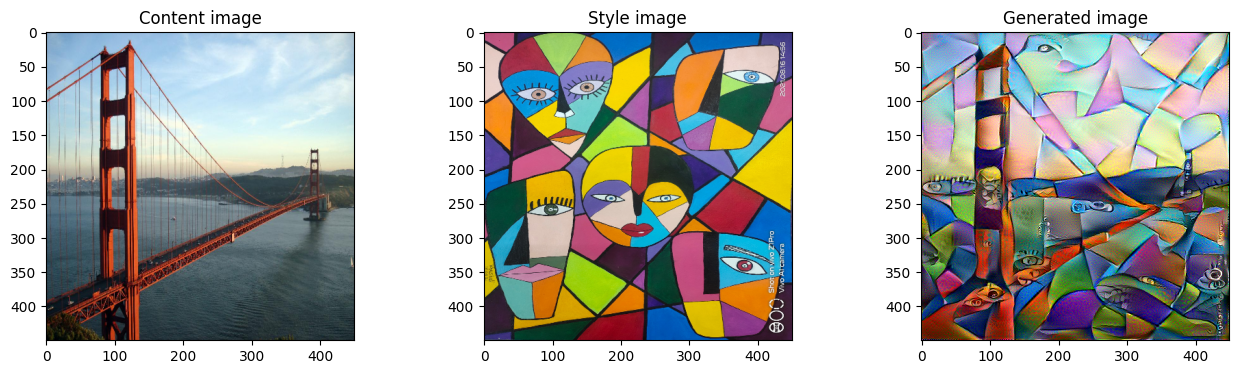

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.imshow(content_image)
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
plt.imshow(style_image)
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
plt.imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

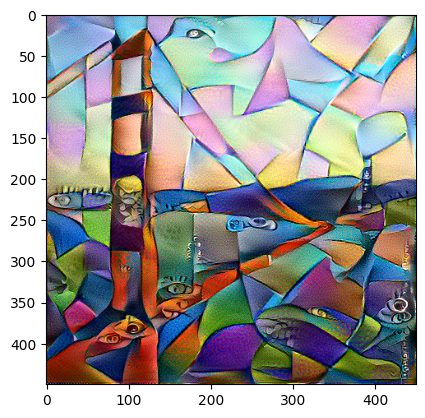

In [ ]:
plt.imshow(generated_image[0])
plt.savefig("/content/drive/MyDrive/NST/Generated_Images/GI_4.png")
plt.show()

In [ ]:
vgg.save("/content/drive/MyDrive/NST/VGG19_Model")